In [150]:
import os

import corner
import matplotlib.pyplot as plt
import numpy as np

from starcluster.extract_data import Data
from starcluster.utils import ExpectedValues

from corner import corner as crn
from figaro.mixture import DPGMM
from figaro.utils import get_priors, plot_multidim
from pathlib import Path

n_alot = 10000

%load_ext autoreload
%autoreload 2
#%matplotlib inline
%matplotlib ipympl

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [151]:
data_path = Path(os.getcwd()).joinpath('data/Pleiades-DR3.csv')
outpath = 'data/Pleiades-DR3.hdf5'

galaxy_cand = Path(os.getcwd()).joinpath('data/GAL_candidates-Pleiades.csv')
quasar_cand = Path(os.getcwd()).joinpath('data/QSO_candidates-Pleiades.csv')

## Pleiades - Astrometry

This data comes from the SIMBAD database and represents our reference values to compare with.

`ExpectedValues` class converts a dictionary into galactic coordinates and returns a list containing the six astormetric parameters in the right order to be accepted in a corner plot.

In order they are $l$, $b$, $parallax$, $\mu_{l*}$, $\mu_b$, $v_{rad}$. 

In [152]:
# data from SIMBAD - Pleiades
expected = {'ra': 56.6010,
            'dec': +24.1140,
            'l': 166.4628,
            'b': -23.6146,
            'pmra': 19.997,
            'pmdec': -45.548,
            'radial_velocity': 6.57,
            'parallax': 7.364}

expected = ExpectedValues(expected)

Here the dataset is either converted from a Gaia DR3 csv file (first, raw codeblock) or opened from a saved hdf5 file.

In the case of conversion, the `convert` flag is set to `True`. `ruwe=1.4` sets the upper limit for the *RUWE*, as described in *Lindegren, L. 2018, technical note GAIA-C3-TN-LU-LL-124*. The converted dataset is then saved into a hdf5 file for convenience.

In case you need to open an existing file, `convert` flag is set to `False`.

In [153]:
dataset = Data(path=outpath, convert=False)

In [134]:
l = dataset['l']
b = dataset['b']
plx = dataset['parallax']
pml = dataset['pml']
pmb = dataset['pmb']
v_rad = dataset['radial_velocity']

In [29]:
columns_list = [l, b, plx, pml, pmb, v_rad]

epsilon = 0

bounds = [[l.min() - epsilon, l.max() + epsilon],
          [b.min() - epsilon, b.max() + epsilon],
          [plx.min() - epsilon, plx.max() + epsilon],
          [pml.min() - epsilon, pml.max() + epsilon],
          [pmb.min() - epsilon, pmb.max() + epsilon],
          [v_rad.min() - epsilon, v_rad.max() + epsilon]]

In [30]:
samples = dataset.as_array()

In [31]:
del_idx = []
for idx, data_column in enumerate(columns_list):
    del_idx.append(np.argmin(data_column))
    del_idx.append(np.argmax(data_column))

samples = np.delete(samples, del_idx, axis=0)

In [32]:
prior = get_priors(bounds, samples)

In [33]:
mix = DPGMM(bounds=bounds, prior_pars=prior)

In [34]:
density = mix.density_from_samples(samples)

In [35]:
print(dataset.as_array().shape, density.n_cl)
N_stars = dataset.as_array().shape[0]
print(N_stars)

(4655, 6) 634
4655


### Plot

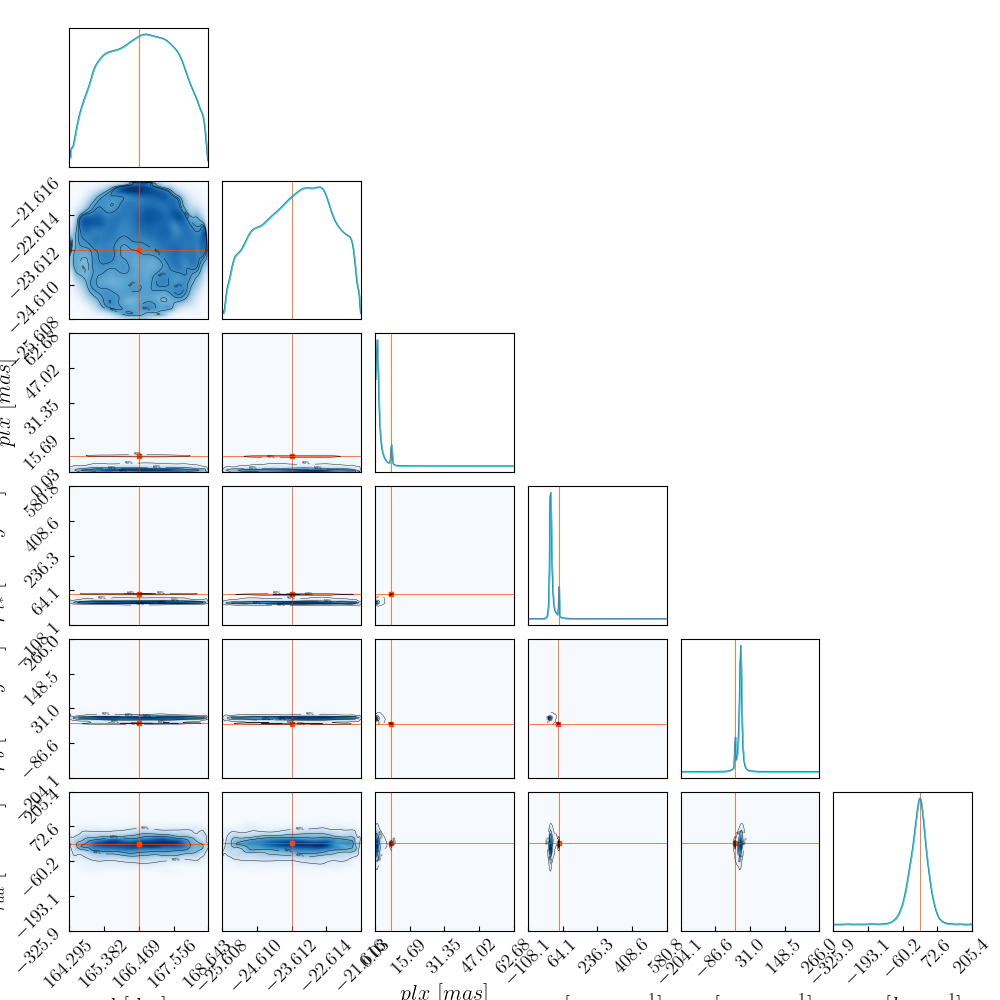

In [36]:
plot_multidim([density],
              out_folder = '.', name = 'density-pleiades',
              labels = [r'l',
                        r'b',
                        r'plx',
                        r'\mu_{l*}',
                        r'\mu_b',
                        r'v_{rad}'],
              units = [r'deg',
                       r'deg',
                       r'mas',
                       r'mas\,yr^{-1}',
                       r'mas\,yr^{-1}',
                       r'km\,s^{-1}'],
              show = True, save = True, subfolder = False,
              n_pts = 200,
              true_value = expected(),
              figsize = 10, levels = [0.5, 0.68, 0.9])

In [154]:
from starcluster.analysis.select_stars import by_parallax

cluster = by_parallax(dataset, parallax_min=7, parallax_max=8)

In [155]:
from starcluster.analysis.view_stars import as_cartesian_array, quiver_plot, equatorial_quiver_plot

cluster_cart, v = as_cartesian_array(cluster)

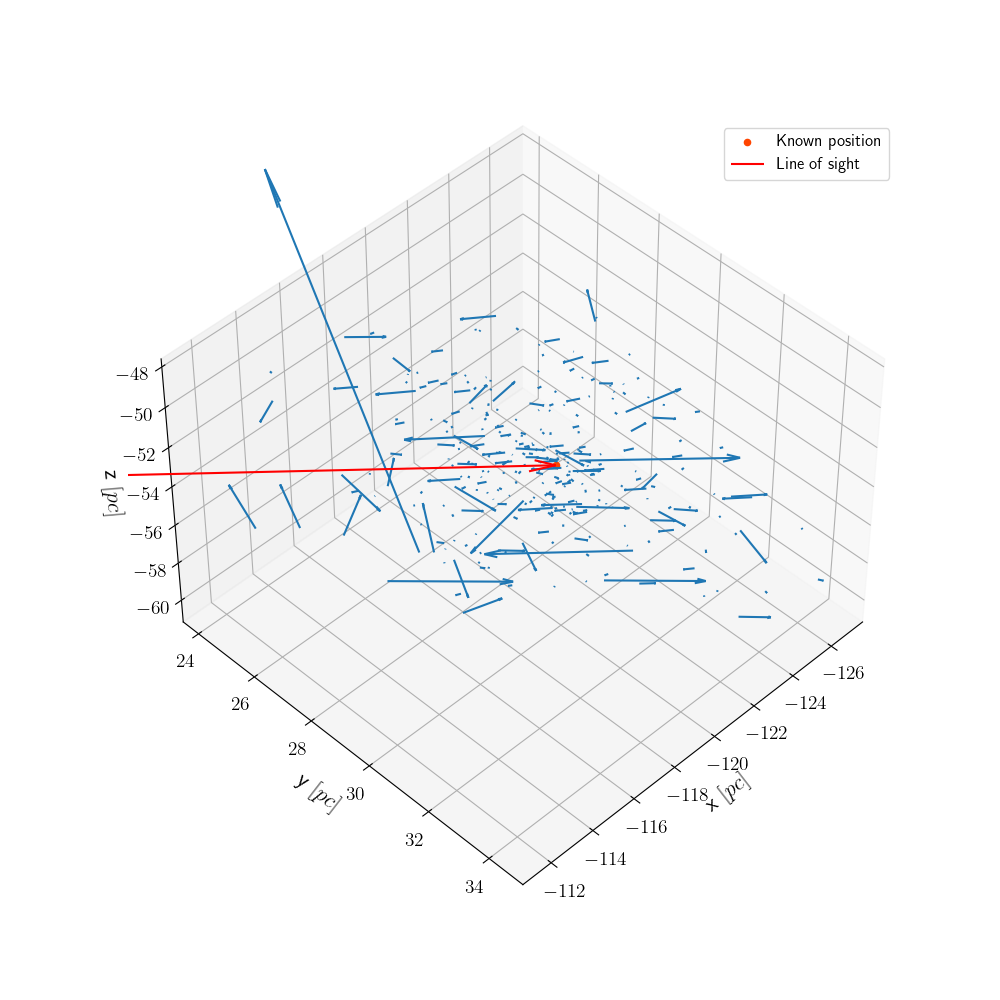

In [156]:
quiver_plot(cluster_cart,
            out_folder='.', name='cart_3d_pleiades',
            show=True, save=True, subfolder=True,
            true_value=expected(),
            figsize=10,
            scale=3e1,
            line_of_sight=True)

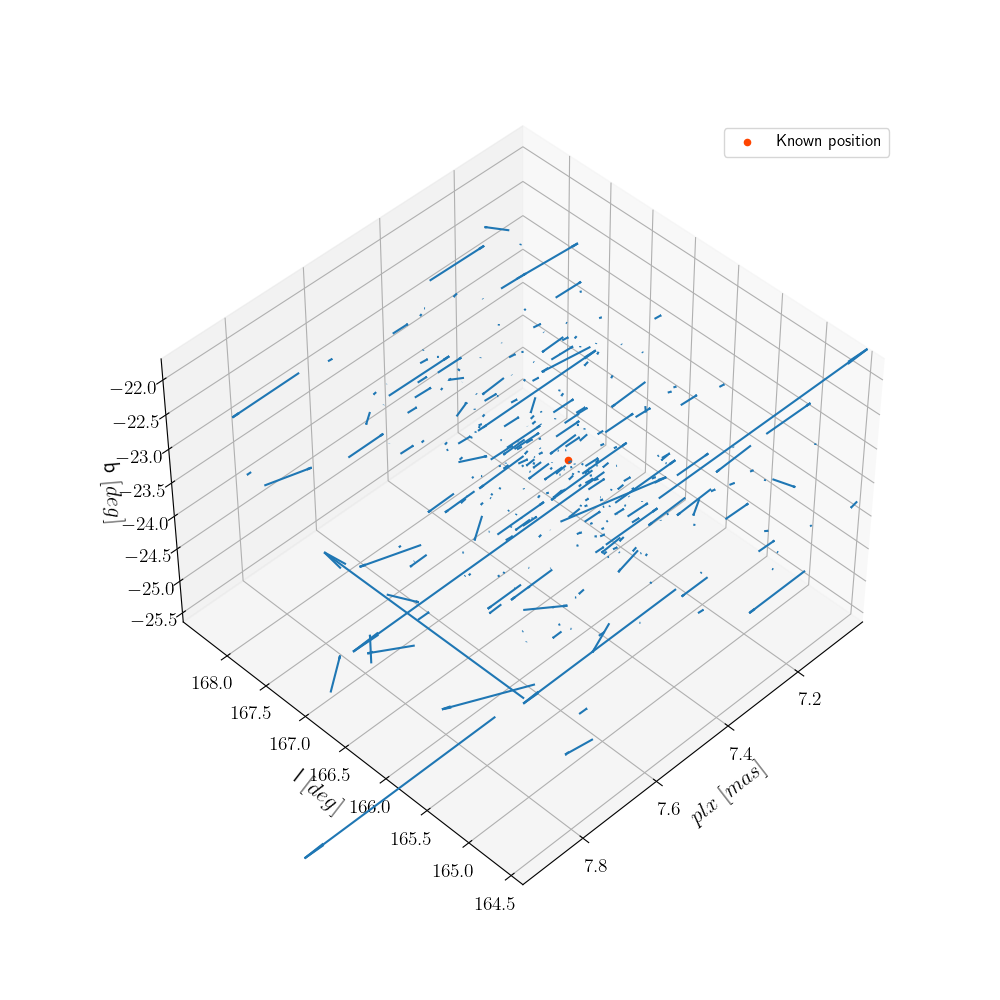

In [157]:
equatorial_quiver_plot(cluster,
                       out_folder='.', name='equatorial_3d_pleiades',
                       show=True, save=True, subfolder=True,
                       true_value=expected(),
                       figsize=10,
                       scale=3e2)

In [22]:
dist = cluster_cart['x']**2 + cluster_cart['y']**2 + cluster_cart['z']**2
dist = np.sqrt(dist)

(array([ 3.,  0.,  3.,  4.,  1.,  0.,  6.,  3.,  5.,  4.,  1.,  9.,  8.,
        27., 67., 94., 70., 27.,  7., 10.,  6.,  4.,  5.,  2.,  3.,  4.,
         2.,  4.,  3.,  5.,  2.,  3.]),
 array([105.9995086 , 107.88563063, 109.77175266, 111.65787469,
        113.54399672, 115.43011875, 117.31624078, 119.20236281,
        121.08848484, 122.97460687, 124.8607289 , 126.74685093,
        128.63297296, 130.51909498, 132.40521701, 134.29133904,
        136.17746107, 138.0635831 , 139.94970513, 141.83582716,
        143.72194919, 145.60807122, 147.49419325, 149.38031528,
        151.26643731, 153.15255934, 155.03868137, 156.92480339,
        158.81092542, 160.69704745, 162.58316948, 164.46929151,
        166.35541354]),
 <BarContainer object of 32 artists>)

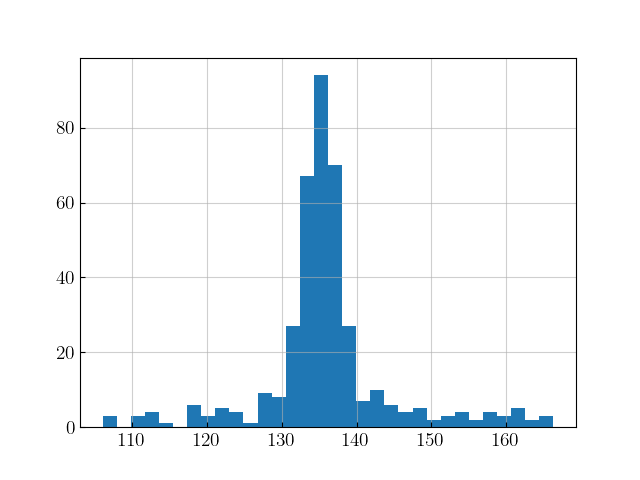

In [23]:
fig2 = plt.figure()
ax = fig2.gca()
ax.hist(dist, bins=32)

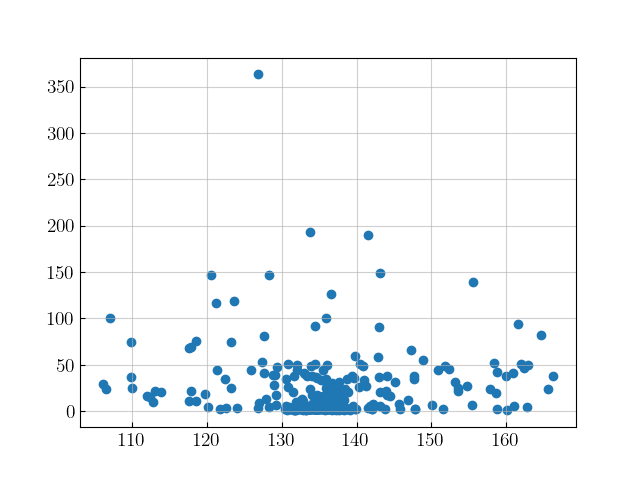

In [24]:
fig3 = plt.figure()
ax = fig3.gca()
ax.scatter(dist, v)

## M4

In [54]:
data_path = Path(os.getcwd()).joinpath('data/M4-DR3.csv')
outpath = 'data/M4-DR3.hdf5'

# data from SIMBAD - M4
expected = {'ra': 245.89675,
            'dec': -26.52575,
            'l': 350.97293,
            'b': +15.97218,
            'pmra': -12.48,
            'pmdec': -18.99,
            'radial_velocity': 71.05,
            'parallax': 0.556}
expected = ExpectedValues(expected)

galaxy_cand = Path(os.getcwd()).joinpath('data/GAL_candidates-M4.csv')
quasar_cand = Path(os.getcwd()).joinpath('data/QSO_candidates-M4.csv')

In [55]:
dataset = Data(path=outpath, convert=False)

In [54]:
l = dataset['l']
b = dataset['b']
plx = dataset['parallax']
pml = dataset['pml']
pmb = dataset['pmb']
v_rad = dataset['radial_velocity']

In [55]:
columns_list = [l, b, plx, pml, pmb, v_rad]

epsilon = 0

bounds = [[l.min() - epsilon, l.max() + epsilon],
          [b.min() - epsilon, b.max() + epsilon],
          [plx.min() - epsilon, plx.max() + epsilon],
          [pml.min() - epsilon, pml.max() + epsilon],
          [pmb.min() - epsilon, pmb.max() + epsilon],
          [v_rad.min() - epsilon, v_rad.max() + epsilon]]

In [56]:
samples = dataset.as_array()

In [57]:
del_idx = []
for idx, data_column in enumerate(columns_list):
    del_idx.append(np.argmin(data_column))
    del_idx.append(np.argmax(data_column))

samples = np.delete(samples, del_idx, axis=0)

In [58]:
prior = get_priors(bounds, samples)

In [59]:
mix = DPGMM(bounds=bounds, prior_pars=prior)

In [60]:
density = mix.density_from_samples(samples)

In [61]:
print(dataset.as_array().shape, density.n_cl)
N_stars = dataset.as_array().shape[0]
print(N_stars)

(620, 6) 139
620


### Plot

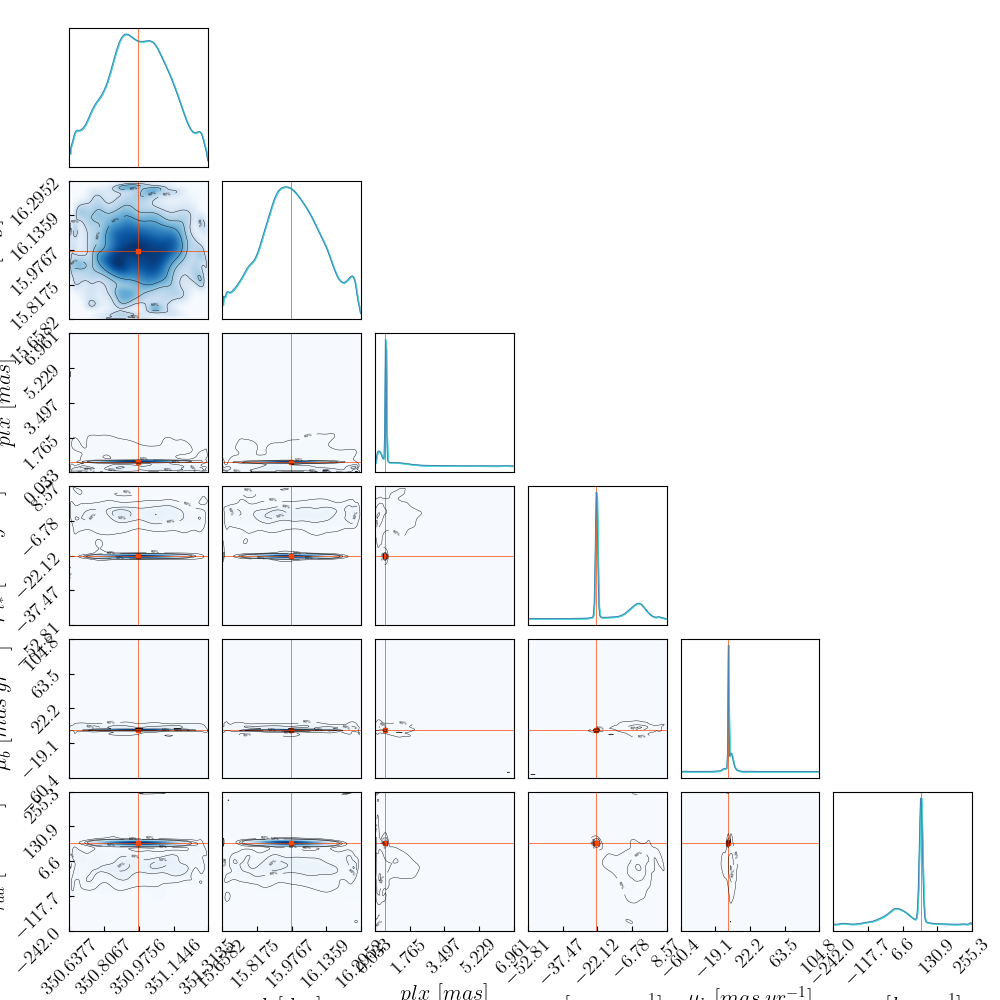

In [62]:
plot_multidim([density],
              out_folder = '.', name = 'density-M4',
              labels = [r'l',
                        r'b',
                        r'plx',
                        r'\mu_{l*}',
                        r'\mu_b',
                        r'v_{rad}'],
              units = [r'deg',
                       r'deg',
                       r'mas',
                       r'mas\,yr^{-1}',
                       r'mas\,yr^{-1}',
                       r'km\,s^{-1}'],
              show = True, save = True, subfolder = False,
              n_pts = 200,
              true_value = expected(),
              figsize = 10, levels = [0.5, 0.68, 0.9])

In [56]:
from starcluster.analysis.select_stars import by_proper_motion

cluster = by_proper_motion(dataset, axis='l', pm_min=-26, pm_max=-18)

In [57]:
from starcluster.analysis.view_stars import as_cartesian_array, quiver_plot

cluster_cart, v = as_cartesian_array(cluster)

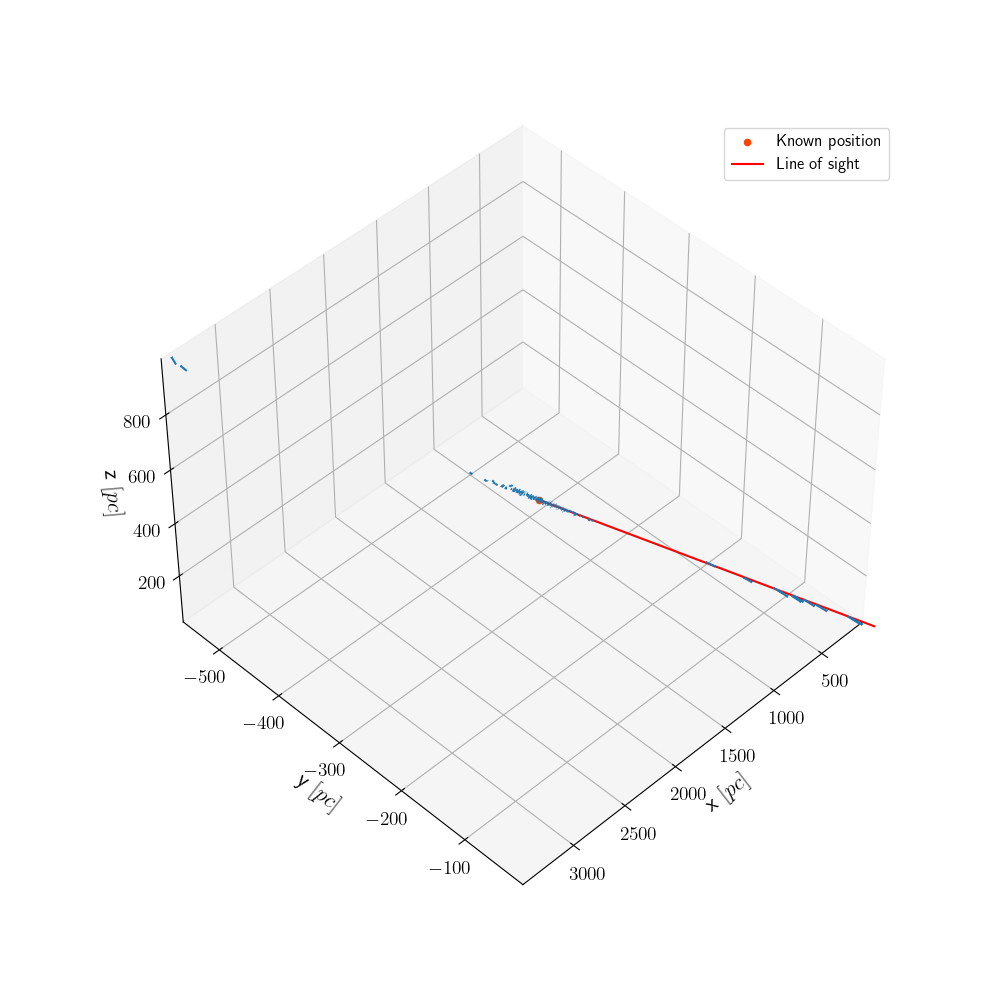

In [59]:
quiver_plot(cluster_cart,
            out_folder='.', name='cart_3d_M4',
            show = True, save = True, subfolder = True,
            true_value = expected(),
            figsize = 10,
            scale=10,
            line_of_sight=True)

In [60]:
dist = cluster_cart['x']**2 + cluster_cart['y']**2 + cluster_cart['z']**2
dist = np.sqrt(dist)

(array([  2.,   1.,   3.,   2.,   0.,   1.,   0.,   1.,   0.,   0.,   0.,
          0.,   1.,  22., 122., 127.,  27.,   6.,   1.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   2.]),
 array([ 143.65867157,  251.55020585,  359.44174012,  467.3332744 ,
         575.22480868,  683.11634296,  791.00787724,  898.89941152,
        1006.7909458 , 1114.68248008, 1222.57401436, 1330.46554864,
        1438.35708292, 1546.2486172 , 1654.14015148, 1762.03168576,
        1869.92322004, 1977.81475431, 2085.70628859, 2193.59782287,
        2301.48935715, 2409.38089143, 2517.27242571, 2625.16395999,
        2733.05549427, 2840.94702855, 2948.83856283, 3056.73009711,
        3164.62163139, 3272.51316567, 3380.40469995, 3488.29623422,
        3596.1877685 ]),
 <BarContainer object of 32 artists>)

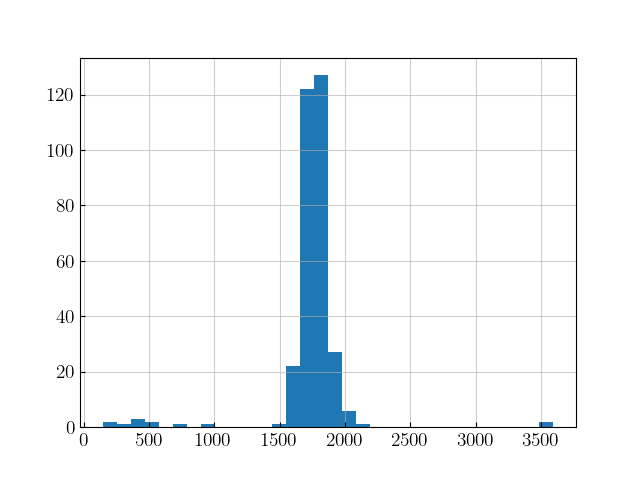

In [61]:
fig2 = plt.figure()
ax = fig2.gca()
ax.hist(dist, bins=32)

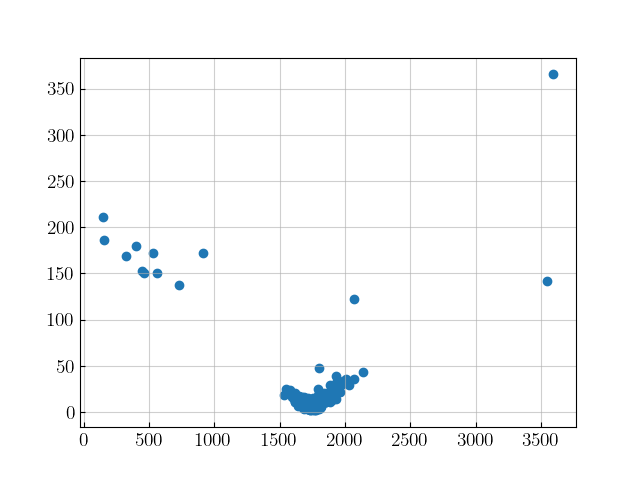

In [32]:
fig3 = plt.figure()
ax = fig3.gca()
ax.scatter(dist, v)

## Omega Centauri

In [33]:
data_path = Path(os.getcwd()).joinpath('data/OmegaCen-DR3.csv')
outpath = 'data/OmegaCen-DR3.hdf5'

# data from SIMBAD - OmegaCen
expected = {'ra': 201.69700,
            'dec': -47.47947,
            'l': 309.10202,
            'b': +14.96833,
            'pmra': -3.24,
            'pmdec': -6.73,
            'radial_velocity': 234.28,
            'parallax': 0.193}
expected = ExpectedValues(expected)

galaxy_cand = Path(os.getcwd()).joinpath('data/GAL_candidates-OmegaCen.csv')
quasar_cand = Path(os.getcwd()).joinpath('data/QSO_candidates-OmegaCen.csv')

In [34]:
dataset = Data(path=outpath, convert=False)

In [87]:
l = dataset['l']
b = dataset['b']
plx = dataset['parallax']
pml = dataset['pml']
pmb = dataset['pmb']
v_rad = dataset['radial_velocity']

In [88]:
columns_list = [l, b, plx, pml, pmb, v_rad]

epsilon = 0

bounds = [[l.min() - epsilon, l.max() + epsilon],
          [b.min() - epsilon, b.max() + epsilon],
          [plx.min() - epsilon, plx.max() + epsilon],
          [pml.min() - epsilon, pml.max() + epsilon],
          [pmb.min() - epsilon, pmb.max() + epsilon],
          [v_rad.min() - epsilon, v_rad.max() + epsilon]]

In [89]:
samples = dataset.as_array()

In [90]:
del_idx = []
for idx, data_column in enumerate(columns_list):
    del_idx.append(np.argmin(data_column))
    del_idx.append(np.argmax(data_column))

samples = np.delete(samples, del_idx, axis=0)

In [91]:
prior = get_priors(bounds, samples)

In [92]:
mix = DPGMM(bounds=bounds, prior_pars=prior)

In [93]:
density = mix.density_from_samples(samples)

In [94]:
print(dataset.as_array().shape, density.n_cl)
N_stars = dataset.as_array().shape[0]
print(N_stars)

(1815, 6) 183
1815


### Plot

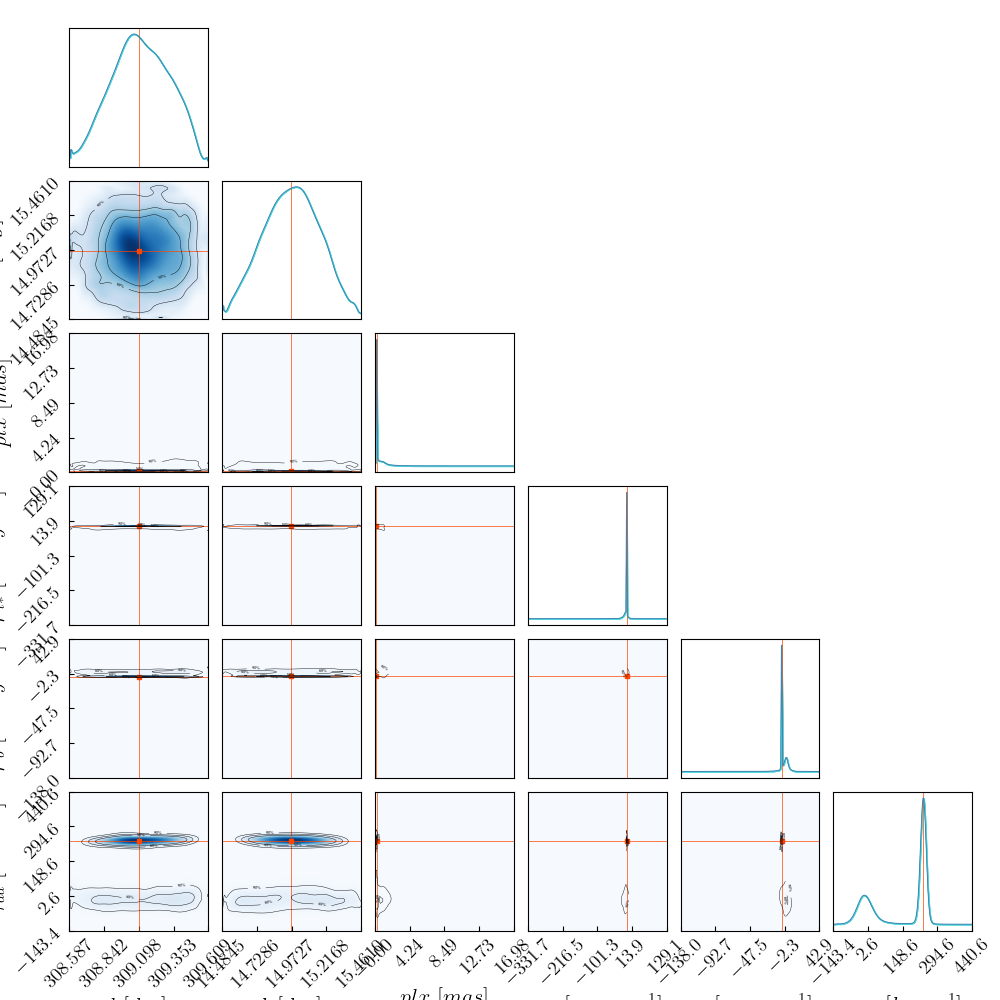

In [95]:
plot_multidim([density],
              out_folder = '.', name = 'density-OmegaCen',
              labels = [r'l',
                        r'b',
                        r'plx',
                        r'\mu_{l*}',
                        r'\mu_b',
                        r'v_{rad}'],
              units = [r'deg',
                       r'deg',
                       r'mas',
                       r'mas\,yr^{-1}',
                       r'mas\,yr^{-1}',
                       r'km\,s^{-1}'],
              show = True, save = True, subfolder = False,
              n_pts = 200,
              true_value = expected(),
              figsize = 10, levels = [0.5, 0.68, 0.9])

In [36]:
from starcluster.analysis.select_stars import by_radial_velocity

cluster = by_radial_velocity(dataset, radial_velocity_min=190, radial_velocity_max=290)
cluster = by_parallax(cluster, parallax_min=1/5e4)

In [37]:
from starcluster.analysis.view_stars import as_cartesian_array, quiver_plot

cluster_cart, v = as_cartesian_array(cluster)

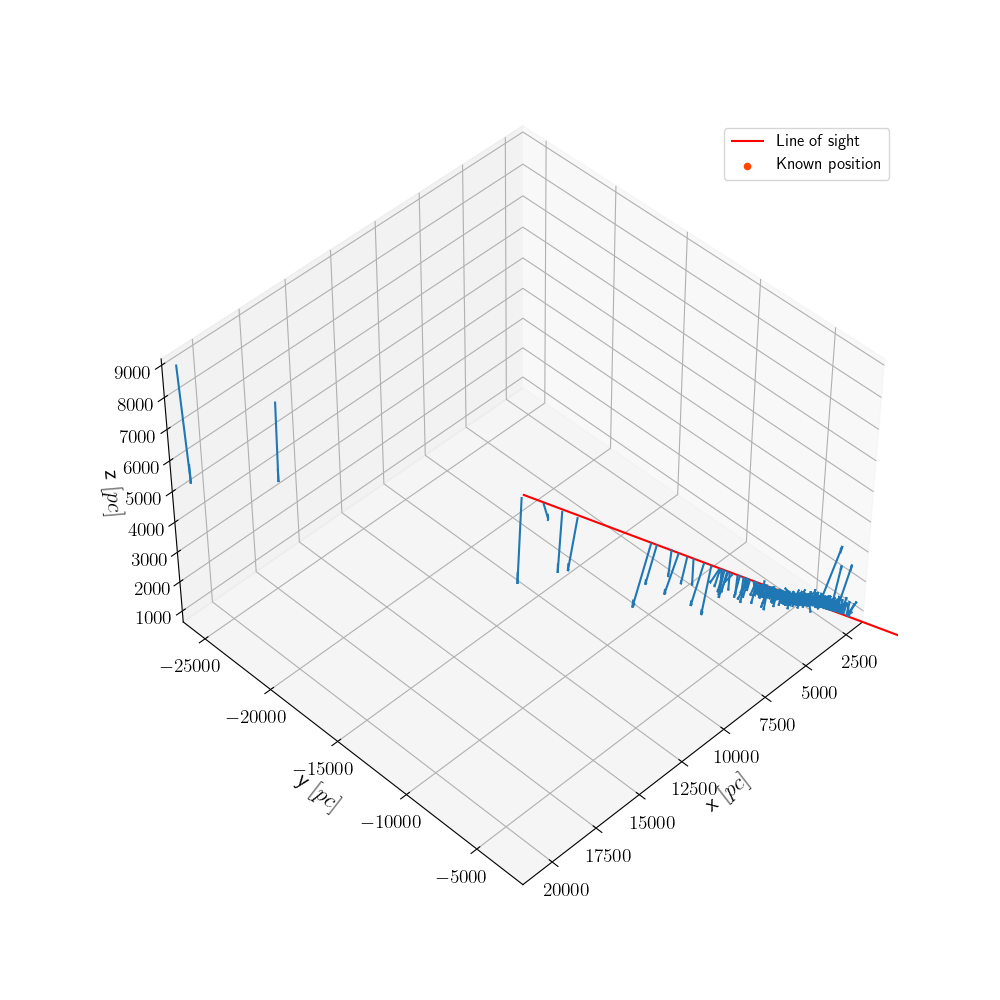

In [38]:
quiver_plot(cluster_cart,
            out_folder='.', name='cart_3d_OmegaCen',
            show = True, save = True, subfolder = True,
            true_value = expected(),
            figsize = 10,
            scale=1e-1,
            line_of_sight=True)

In [108]:
dist = cluster_cart['x']**2 + cluster_cart['y']**2 + cluster_cart['z']**2
dist = np.sqrt(dist)

(array([314., 163.,  80., 230., 564., 322.,  88.,  17.,  13.,   5.,   5.,
          3.,   1.,   0.,   2.,   1.,   1.,   1.,   1.,   1.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   1.]),
 array([   58.90951003,  1147.99929766,  2237.0890853 ,  3326.17887294,
         4415.26866058,  5504.35844821,  6593.44823585,  7682.53802349,
         8771.62781112,  9860.71759876, 10949.8073864 , 12038.89717403,
        13127.98696167, 14217.07674931, 15306.16653695, 16395.25632458,
        17484.34611222, 18573.43589986, 19662.52568749, 20751.61547513,
        21840.70526277, 22929.79505041, 24018.88483804, 25107.97462568,
        26197.06441332, 27286.15420095, 28375.24398859, 29464.33377623,
        30553.42356387, 31642.5133515 , 32731.60313914, 33820.69292678,
        34909.78271441]),
 <BarContainer object of 32 artists>)

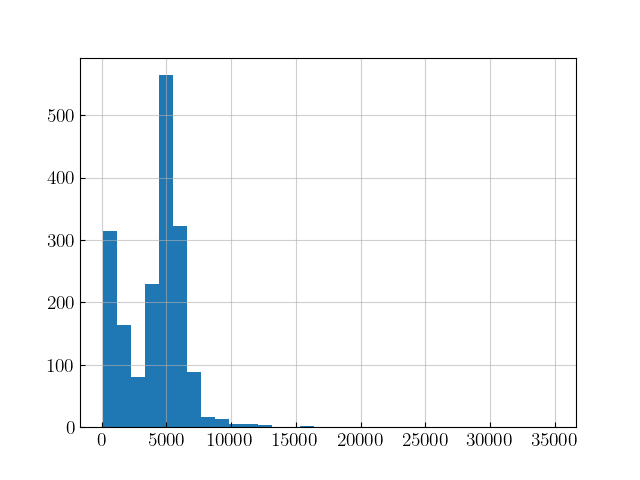

In [109]:
fig2 = plt.figure()
ax = fig2.gca()
ax.hist(dist, bins=32)

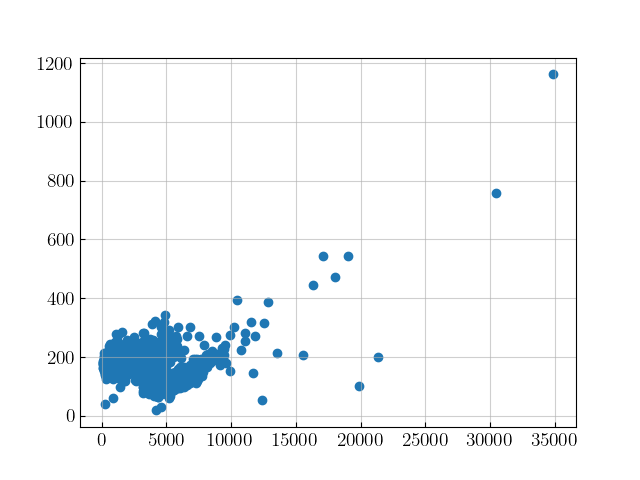

In [110]:
fig3 = plt.figure()
ax = fig3.gca()
ax.scatter(dist, v)

## NGC2516

In [113]:
data_path = Path(os.getcwd()).joinpath('data/NGC2516-DR3.csv')
outpath = 'data/NGC2516-DR3.hdf5'

# data from SIMBAD - NGC2516
expected = {'ra': 119.5270,
            'dec': -60.8000,
            'l': 273.8612,
            'b': -15.8730,
            'pmra': -4.6579,
            'pmdec': 11.1517,
            'radial_velocity': 24.2,
            'parallax': 2.4118}
expected = ExpectedValues(expected)

galaxy_cand = Path(os.getcwd()).joinpath('data/GAL_candidates-NGC2516.csv')
quasar_cand = Path(os.getcwd()).joinpath('data/QSO_candidates-NGC2516.csv')

In [115]:
dataset = Data(path=outpath, convert=False)

In [116]:
l = dataset['l']
b = dataset['b']
plx = dataset['parallax']
pml = dataset['pml']
pmb = dataset['pmb']
v_rad = dataset['radial_velocity']

In [117]:
columns_list = [l, b, plx, pml, pmb, v_rad]

epsilon = 0

bounds = [[l.min() - epsilon, l.max() + epsilon],
          [b.min() - epsilon, b.max() + epsilon],
          [plx.min() - epsilon, plx.max() + epsilon],
          [pml.min() - epsilon, pml.max() + epsilon],
          [pmb.min() - epsilon, pmb.max() + epsilon],
          [v_rad.min() - epsilon, v_rad.max() + epsilon]]

In [118]:
samples = dataset.as_array()

In [119]:
del_idx = []
for idx, data_column in enumerate(columns_list):
    del_idx.append(np.argmin(data_column))
    del_idx.append(np.argmax(data_column))

samples = np.delete(samples, del_idx, axis=0)

In [120]:
prior = get_priors(bounds, samples)

In [121]:
mix = DPGMM(bounds=bounds, prior_pars=prior)

In [122]:
density = mix.density_from_samples(samples)

In [123]:
print(dataset.as_array().shape, density.n_cl)
N_stars = dataset.as_array().shape[0]
print(N_stars)

(10169, 6) 860
10169


### Plot

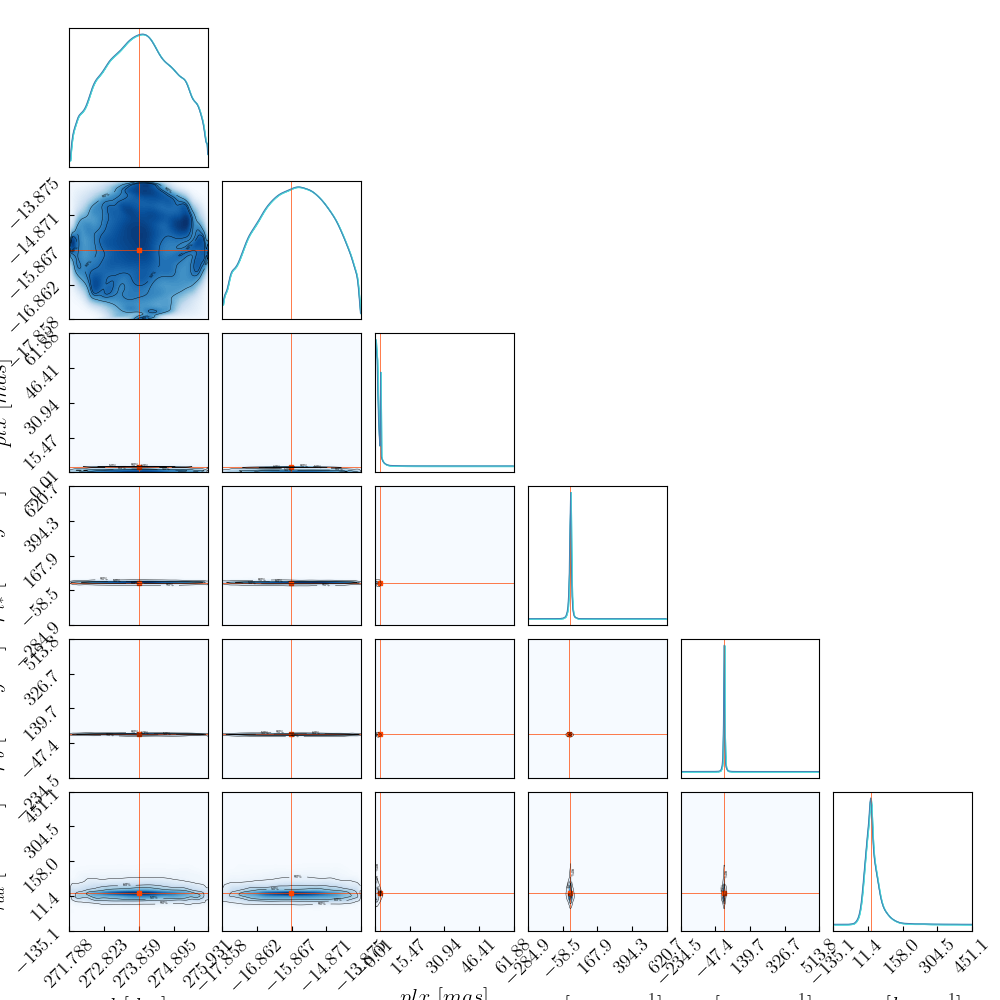

In [124]:
plot_multidim([density],
              out_folder = '.', name = 'density-NGC2516',
              labels = [r'l',
                        r'b',
                        r'plx',
                        r'\mu_{l*}',
                        r'\mu_b',
                        r'v_{rad}'],
              units = [r'deg',
                       r'deg',
                       r'mas',
                       r'mas\,yr^{-1}',
                       r'mas\,yr^{-1}',
                       r'km\,s^{-1}'],
              show = True, save = True, subfolder = False,
              n_pts = 200,
              true_value = expected(),
              figsize = 10, levels = [0.5, 0.68, 0.9])

In [137]:
from starcluster.analysis.select_stars import by_parallax, by_proper_motion

cluster = by_parallax(dataset, parallax_min=2.20, parallax_max=2.66)
cluster = by_proper_motion(cluster, axis='b', pm_min=-2.7, pm_max=3.39)

AttributeError: 'numpy.ndarray' object has no attribute 'gal'

In [135]:
from starcluster.analysis.view_stars import as_cartesian_array, quiver_plot

cluster_cart, v = as_cartesian_array(cluster)

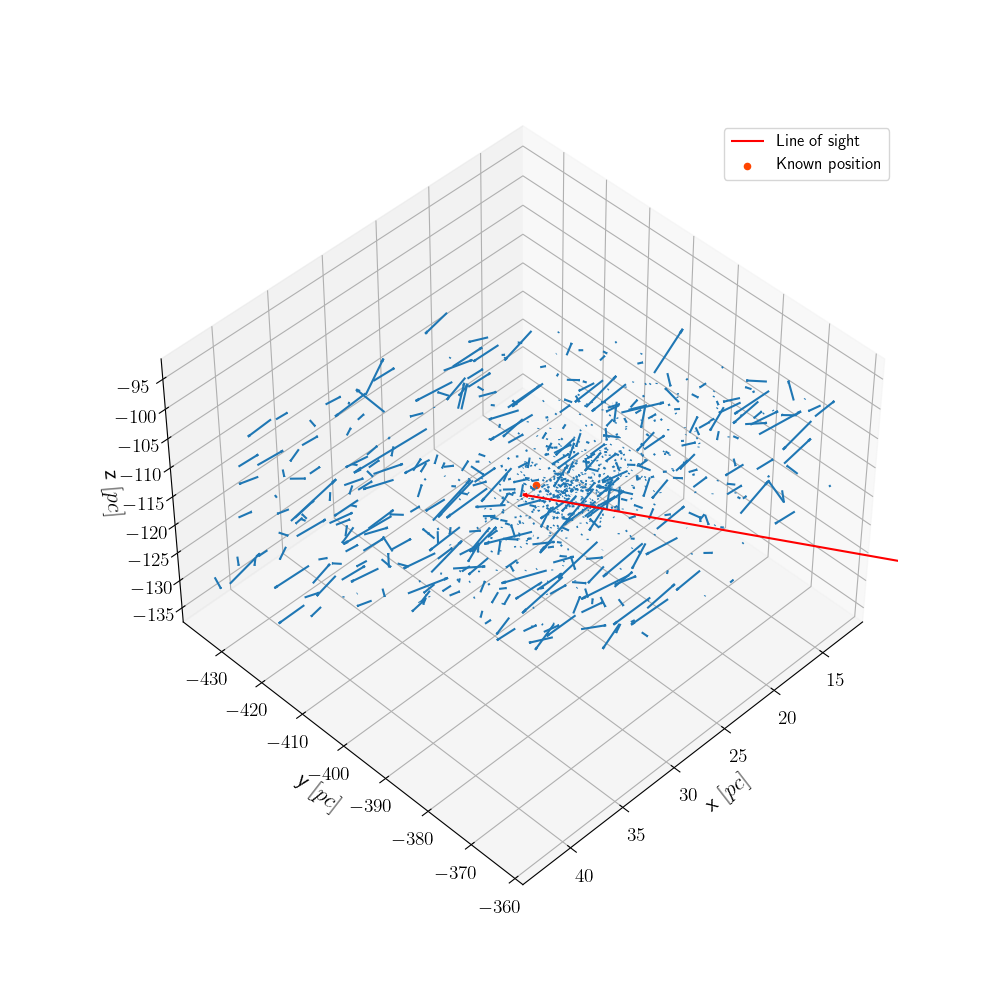

In [136]:
quiver_plot(cluster_cart,
            out_folder='.', name='cart_3d_NGC2516',
            show = True, save = True, subfolder = True,
            true_value = expected(),
            figsize = 10,
            scale=20,
            line_of_sight=True)

In [131]:
dist = cluster_cart['x']**2 + cluster_cart['y']**2 + cluster_cart['z']**2
dist = np.sqrt(dist)

(array([ 19.,   8.,  15.,  12.,  14.,  16.,  13.,  23.,  21.,  28.,  49.,
         76., 146., 164., 151.,  55.,  45.,  24.,  16.,  23.,  21.,  19.,
         17.,  16.,  17.,  17.,  16.,  11.,  16.,  25.,  18.,  30.]),
 array([362.32646207, 365.6692652 , 369.01206833, 372.35487146,
        375.69767459, 379.04047772, 382.38328086, 385.72608399,
        389.06888712, 392.41169025, 395.75449338, 399.09729651,
        402.44009964, 405.78290277, 409.1257059 , 412.46850903,
        415.81131216, 419.15411529, 422.49691842, 425.83972156,
        429.18252469, 432.52532782, 435.86813095, 439.21093408,
        442.55373721, 445.89654034, 449.23934347, 452.5821466 ,
        455.92494973, 459.26775286, 462.61055599, 465.95335912,
        469.29616226]),
 <BarContainer object of 32 artists>)

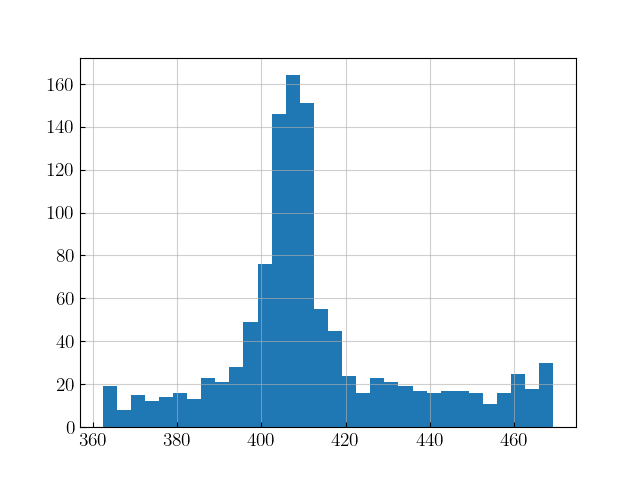

In [132]:
fig2 = plt.figure()
ax = fig2.gca()
ax.hist(dist, bins=32)

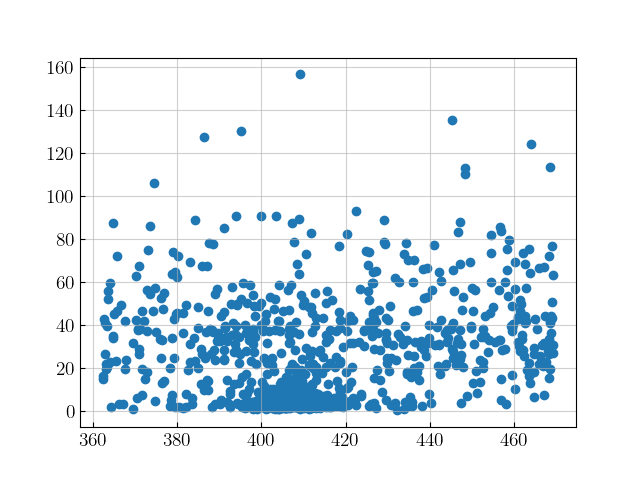

In [133]:
fig3 = plt.figure()
ax = fig3.gca()
ax.scatter(dist, v)